In [146]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pprint as pp
#import os
import ast
import pandas_profiling as p_p
import statsmodels.api as sm
import scipy.stats as scs
from sklearn import preprocessing
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

In [58]:
train_df = pd.read_csv('Data/train.csv')
test_df = pd.read_csv('Data/test.csv')

In [59]:
train_df.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

In [60]:
# Make a list of initial columns to drop
drop_cols = ['id', 'belongs_to_collection', 'genres', 'homepage', 'imdb_id', 'original_language', 'original_title',
             'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 
             'spoken_languages', 'status', 'tagline', 'Keywords', 'cast', 'crew']

In [61]:
df_1 = train_df.copy()

In [62]:
df_1.drop(labels=drop_cols, axis=1, inplace=True)

In [63]:
print(df_1.info())
df_1.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
budget     3000 non-null int64
runtime    2998 non-null float64
title      3000 non-null object
revenue    3000 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 93.8+ KB
None


,budget,runtime,revenue
count,3.000000e+03,2998.000000,3.000000e+03
mean,2.253133e+07,107.856571,6.672585e+07
std,3.702609e+07,22.086434,1.375323e+08
min,0.000000e+00,0.000000,1.000000e+00
25%,0.000000e+00,94.000000,2.379808e+06
50%,8.000000e+06,104.000000,1.680707e+07
75%,2.900000e+07,118.000000,6.891920e+07
max,3.800000e+08,338.000000,1.519558e+09


In [64]:
print(np.count_nonzero(df_1["budget"]))
np.count_nonzero(df_1["revenue"])

2188


3000

In [65]:
# All of revenue is non-zero, but 812 budget is zero...drop, for now

In [86]:
# Get names of indexes for which column budget less than budg_cutoff
budg_cutoff = 1000
budg_drop_indices = df_1[ df_1['budget'] < budg_cutoff ].index
 
# Delete these row indices from DataFrame because they're unlikely/impossible
df_1.drop(budg_drop_indices , inplace=True)

In [109]:
df_1[df_1.runtime.isnull()].title


1335    Королёв
Name: title, dtype: object

In [115]:
# The runtime for Королёв is NaN. Will put data from IMDB for this movie.
df_1.at[1335, 'runtime']=130
print(df_1[df_1.runtime.isnull().values])



Empty DataFrame
Columns: [budget, runtime, title, revenue]
Index: []


In [116]:
print(df_1.info())
df_1.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2170 entries, 0 to 2999
Data columns (total 4 columns):
budget     2170 non-null int64
runtime    2170 non-null float64
title      2170 non-null object
revenue    2170 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 164.8+ KB
None


,budget,runtime,revenue
count,2.170000e+03,2170.000000,2.170000e+03
mean,3.114931e+07,110.083871,8.760923e+07
std,4.033572e+07,22.473269,1.559548e+08
min,2.500000e+03,0.000000,3.000000e+00
25%,5.625000e+06,96.000000,7.014040e+06
50%,1.645000e+07,106.000000,2.925229e+07
75%,4.000000e+07,121.000000,1.004246e+08
max,3.800000e+08,338.000000,1.519558e+09


In [117]:
df_1[df_1.budget < 50000].title

254                           Voracious
259                       The Terrorist
267                              Clerks
365                              Primer
653                                Cure
1230                Paranormal Activity
1356                    Lost in the Sun
1803                         Quiet City
1893                     Pink Flamingos
2610    The Tiger: An Old Hunter's Tale
2781    Blood, Guts, Bullets and Octane
2786                         Bellflower
2855                          Following
Name: title, dtype: object

In [159]:
y = df_1['revenue']
X = df_1[['budget','runtime']]
X.head()

,budget,runtime
0,14000000,93.0
1,40000000,113.0
2,3300000,105.0
3,1200000,122.0
5,8000000,83.0


In [160]:
X.runtime.mean()

110.08387096774193

In [161]:
X.budget.mean()

31149309.21705069

In [162]:
X.head(2)

,budget,runtime
0,14000000,93.0
1,40000000,113.0


In [163]:
#Scaling features budget and runtime
scaled_features = preprocessing.StandardScaler().fit_transform(X.values)
print(scaled_features[:2,:])
X_scaled = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
X_scaled.head(2)

[[-0.42526231 -0.7603615 ]
 [ 0.2194762   0.1297898 ]]


,budget,runtime
0,-0.425262,-0.760362
1,0.219476,0.129790


In [165]:
# Now add constant for model
X_scaled_c = sm.add_constant(X_scaled[['budget','runtime']])
X_scaled_c.describe()   #Check the means and std-devs

,const,budget,runtime
count,2170.0,2.170000e+03,2.170000e+03
mean,1.0,3.490551e-17,2.205225e-16
std,0.0,1.000230e+00,1.000230e+00
min,1.0,-7.723672e-01,-4.899565e+00
25%,1.0,-6.329425e-01,-6.268388e-01
50%,1.0,-3.645081e-01,-1.817632e-01
75%,1.0,2.194762e-01,4.858503e-01
max,1.0,8.650672e+00,1.014399e+01


In [166]:
scaler = preprocessing.StandardScaler().fit(X_scaled_c)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [168]:
print(scaler.scale_)                           

[1. 1. 1.]


In [170]:
model = sm.OLS(y, X_scaled_c)
results = model.fit()
results.summary()                                  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     1317.
Date:                Tue, 15 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:52:17   Log-Likelihood:                -43153.
No. Observations:                2170   AIC:                         8.631e+04
Df Residuals:                    2167   BIC:                         8.633e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.761e+07   2.25e+06     38.934      0.000    8.32e+07     9.2e+07
budget      1.137e+08   2.31e+06     49.271      0.000    1.09e+08    1.18e+08
runtime     7.263e+06   2.31e+06      3.148      0.002    2.74e+06    1.18e+07
==============================================================================
Omnibus:                     1344.547   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25946.011
Skew:                           2.571   Prob(JB):                         0.00
Kurtosis:                      19.141   Cond. No.                         1.25
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [120]:
# Use a bemchmary to comopare against RMSE 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     1317.
Date:                Tue, 15 Oct 2019   Prob (F-statistic):               0.00
Time:                        11:41:15   Log-Likelihood:                -43153.
No. Observations:                2170   AIC:                         8.631e+04
Df Residuals:                    2167   BIC:                         8.633e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.578e+07   1.13e+07     -3.173      0.002   -5.79e+07   -1.37e+07
budget         2.8188      0.057     49.271      0.000       2.707       2.931
runtime     3.233e+05   1.03e+05      3.148      0.002    1.22e+05    5.25e+05
==============================================================================
Omnibus:                     1344.547   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25946.011
Skew:                           2.571   Prob(JB):                         0.00
Kurtosis:                      19.141   Cond. No.                     2.55e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.55e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [172]:
X_scaled_c.head()

,const,budget,runtime
0,1.0,-0.425262,-0.760362
1,1.0,0.219476,0.129790
2,1.0,-0.690597,-0.226271
3,1.0,-0.742672,0.530358
5,1.0,-0.574048,-1.205437


In [173]:
print('Parameters: ', results.params)
print('R2: ', results.rsquared)

Parameters:  const      8.760923e+07
budget     1.136716e+08
runtime    7.262940e+06
dtype: float64
R2:  0.5486661798612613


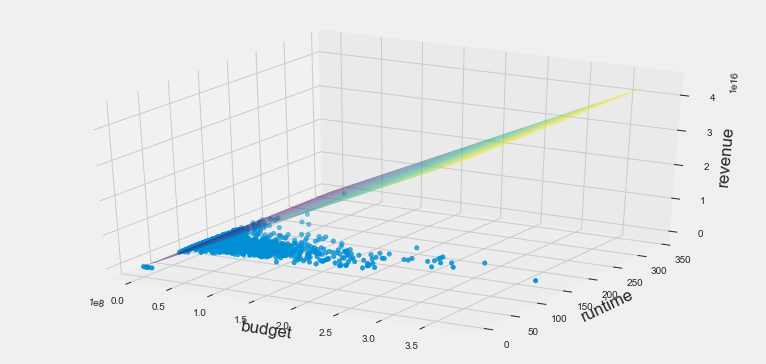

In [174]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_1['budget'], df_1['runtime'], df_1['revenue']);
ax.set_zlabel('revenue')
ax.set_xlabel('budget')
ax.set_ylabel('runtime');

xx1 = np.linspace(df_1['budget'].min(), df_1['budget'].max(), 20)
xx2 = np.linspace(df_1['runtime'].min(), df_1['runtime'].max(), 20)
xx1, xx2 = np.meshgrid(xx1, xx2)
best_plane = (results.params['const'] +
              results.params['budget']*xx1 +
              results.params['runtime']*xx2)

# Plot the surface.
surf = ax.plot_surface(xx1, xx2, best_plane, color='k', alpha=.6, cmap='viridis')